In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os

%matplotlib inline
import IPython.display as ipd

In [2]:
SPEECH_DATA_PATH = 'D:/musan/musan/speech/librivox'
NOISE1_DATA_PATH = 'D:/musan/musan/noise/sound-bible'
NOISE2_DATA_PATH = 'D:/musan/musan/noise/free-sound'
MUSIC_DATA_PATH = 'D:/musan/musan/music'
MUSIC_FOLDERS = ['fma', 'fma-western-art', 'hd-classical', 'rfm']
TARGET_FOLDER = 'D:/musan/preprocessed'
NUM_VALID_FILES = 20

SR = 16000
SNR_RATES = [-10, -5, 0, 5, 10, 15, 20]

CUT_OFF = 4000
FFT_SIZE = 512
FFT_STEP = SR / FFT_SIZE
FRAME_SIZE = FFT_SIZE # 32ms for SR = 16kHz
FRAME_OFFSET =  128
VOICE_THRESHOLD = 7

N_HARM = 14
N_CAND = 100
F0_RANGE = (70, 350)

Dataset: https://arxiv.org/pdf/1510.08484.pdf

## Setup SNR

\begin{equation}
SNR = 20 * log_{10}\left(\frac{A}{k*A_n}\right) => k=10^{log_{10}\left(\frac{A}{A_n}\right)-\frac{SNR}{20}}
\end{equation}

Since the signal power ($A$ and $A_n$) is a quadratic value, the coefficient $k$ also has a quadratic value. Therefore, the actual value of the coefficient $k$ for multiply the noise signal in order to obtain the given $SNR$ is calculated by the formula:

\begin{equation}
k=10^{\frac{log_{10}\left(\frac{A}{A_n}\right)-\frac{SNR}{20}}{2}}
\end{equation}

In [3]:
def SNR(signal, noise):
    A = np.mean(signal ** 2)
    A_noise = np.mean(noise ** 2)
    snr = 20 * np.log10(A / A_noise)
    
    return snr

In [4]:
def snr_coefficient(target_snr, signal, noise):
    A = np.mean(signal ** 2)
    A_noise = np.mean(noise ** 2)
    
    k = 10 ** ((np.log10(A / A_noise) - target_snr / 20) / 2)
    return k

In [5]:
def mix_sig_noise(signal, noise, target_snr):
    k = snr_coefficient(target_snr, signal, noise)
    scaled_noise = k * noise
    
    if len(scaled_noise) <= len(signal):
        n_repeats = len(signal) // len(scaled_noise) + 1
        scaled_noise = np.tile(scaled_noise, n_repeats)
        
    noisy_signal = signal + scaled_noise[:len(signal)]
    noisy_signal[noisy_signal > 1.] = 1.
    noisy_signal[noisy_signal < -1.] = -1.
    return noisy_signal

In [6]:
y, _ = librosa.load(os.path.join(SPEECH_DATA_PATH, 'speech-librivox-0013.wav'), sr=SR)
# ipd.Audio(y, rate=SR)

In [7]:
y_noise, _ = librosa.load(os.path.join(NOISE1_DATA_PATH, 'noise-sound-bible-0009.wav'), sr=SR)
# ipd.Audio(y_noise, rate=SR)

In [8]:
original_snr = SNR(y, y_noise)

target_snr = -10

k = snr_coefficient(target_snr, y, y_noise)
scaled_y_noise = k * y_noise

snr = SNR(y, scaled_y_noise)

print('Original SNR: %.3f, coefficient: %.3f, target SNR: %.3f' % (original_snr, k, snr))

Original SNR: -25.593, coefficient: 0.408, target SNR: -10.000


In [9]:
noisy_signal = mix_sig_noise(y, y_noise, target_snr)
# ipd.Audio(noisy_signal, rate=SR)

## Data loading

In [10]:
def get_wav_files(path):
    filenames = []
    for f in os.listdir(path):
        if os.path.isfile(os.path.join(path, f)) and f.endswith('.wav'):
            filenames.append(os.path.join(path, f))
            
    return filenames

def get_file_size(path):
    y, _ = librosa.load(path, sr=SR)
    if y.max() > 1:
        print(path, y.max())
    return len(y) / SR

In [11]:
speech_filenames = get_wav_files(SPEECH_DATA_PATH)

noisy_filenames = get_wav_files(NOISE1_DATA_PATH)
noisy_filenames += get_wav_files(NOISE2_DATA_PATH)
# noisy_filenames += get_wav_files(os.path.join(MUSIC_DATA_PATH, MUSIC_FOLDERS[0]))
# noisy_filenames += get_wav_files(os.path.join(MUSIC_DATA_PATH, MUSIC_FOLDERS[1]))
# noisy_filenames += get_wav_files(os.path.join(MUSIC_DATA_PATH, MUSIC_FOLDERS[2]))
# noisy_filenames += get_wav_files(os.path.join(MUSIC_DATA_PATH, MUSIC_FOLDERS[3]))

In [9]:
file_sizes = [get_file_size(f) for f in speech_filenames]
total_size = sum(file_sizes)

print('Total %i speech files with %.1f hours of records' % (len(speech_filenames), total_size/60/60))

file_sizes = [get_file_size(f) for f in noisy_filenames]
total_size = sum(file_sizes)

print('Total %i files with noise (%.1f hours)' % (len(noisy_filenames), total_size/60/60))

Total 173 speech files with 20.4 hours of records
Total 930 files with noise (6.2 hours)


## Features extraction

In [12]:
def get_frames(signal):
    grid_smp = np.arange(0, signal.shape[0] - FRAME_SIZE, FRAME_OFFSET)
    frames = np.zeros(shape=(grid_smp.shape[0], FRAME_SIZE))
    
    for i in range(grid_smp.shape[0]):
        l_i = grid_smp[i]
        r_i = l_i + FRAME_SIZE
        frames[i, :] = signal[l_i:r_i]
    
    return frames

In [13]:
def get_spectr(frames):
    window = np.hamming(frames.shape[1])
    window = np.reshape(window, (1, frames.shape[1]))
    weighted_frames = frames * window
    
    spectr = np.fft.fft(weighted_frames, n=FFT_SIZE, axis=1)
    spectr = spectr / FFT_SIZE * 2
    spectr_log = np.log10(abs(spectr)) 
    
    n_env = int(CUT_OFF // FFT_STEP)
    spectr_log = spectr_log[:, :n_env]
    
    return spectr_log

In [14]:
def get_harmonics(spectr):
    fft_inds = np.zeros(shape=(N_HARM, N_CAND), dtype=np.int32)
    cands = np.linspace(F0_RANGE[0], F0_RANGE[1], N_CAND)
    
    for i in range(N_CAND):
        indices = np.round((1 + np.arange(0, N_HARM)) / 2 * cands[i] / FFT_STEP + 1)
        fft_inds[:, i] = indices.astype(np.int32)

    features = spectr[:, fft_inds]
    features = np.transpose(features, axes=(0, 2, 1))
#     features = features[..., np.newaxis]

    return features

In [15]:
def get_features(signal):
    frames = get_frames(signal)
    spectr = get_spectr(frames)
    features = get_harmonics(spectr)
    
    return features.astype(np.float32)

In [16]:
def get_labels(signal):
    frames = get_frames(signal)
    frames = np.sum(np.abs(frames), axis=1)
    labels = (frames > VOICE_THRESHOLD).astype(np.float32)
    
    return labels

In [17]:
signal, _ = librosa.load(speech_filenames[42], sr=SR)
signal.shape[0] / SR
labels = get_labels(signal[:200000])


In [18]:
preprocessed_labels = []
for label in labels:
    preprocessed_labels += [label] * FRAME_OFFSET

labels.shape[0] * FRAME_OFFSET + 256, signal.shape[0]

(199808, 5323128)

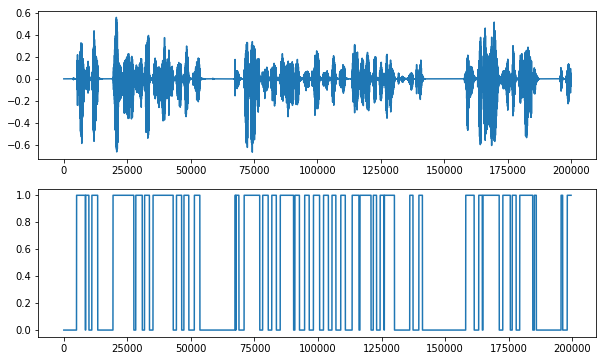

In [19]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(signal[:200000])
plt.subplot(2, 1, 2)
plt.plot(preprocessed_labels)

In [20]:
np.random.shuffle(speech_filenames)
train_filenames = speech_filenames[NUM_VALID_FILES:]
valid_filenames = speech_filenames[:NUM_VALID_FILES]

In [21]:
for i, speech_filename in enumerate(train_filenames):
    print('\r%i/%i' % (i+1, len(train_filenames)), end='')
    signal, _ = librosa.load(speech_filename, sr=SR)
    
    noise_filename = np.random.choice(noisy_filenames)
    noise, _ = librosa.load(noise_filename, sr=SR)
    
    target_snr = np.random.choice(SNR_RATES)
    noisy_signal = mix_sig_noise(signal, noise, target_snr)
    
    features = get_features(noisy_signal)
    labels = get_labels(signal)
        
    target_filename = os.path.join(TARGET_FOLDER, 'noisy_speech_v2', 'train', os.path.basename(speech_filename))
    np.savez(target_filename, features=features, labels=labels)
    
    k = snr_coefficient(target_snr, signal, noise)
    scaled_noise = k * noise
    noise_features = get_features(scaled_noise)
    noise_labels = np.zeros(shape=(noise_features.shape[0]), dtype=np.float32)
    target_filename = os.path.join(TARGET_FOLDER, 'noisy_speech_v2', 'train', os.path.basename(noise_filename))
    np.savez(target_filename, features=noise_features, labels=noise_labels)

153/153

In [23]:
for i, speech_filename in enumerate(valid_filenames):
    print('\r%i/%i' % (i+1, len(valid_filenames)), end='')
    signal, _ = librosa.load(speech_filename, sr=SR)
    
    noise_filename = np.random.choice(noisy_filenames)
    noise, _ = librosa.load(noise_filename, sr=SR)
    
    target_snr = np.random.choice(SNR_RATES)
    noisy_signal = mix_sig_noise(signal, noise, target_snr)
    
    features = get_features(noisy_signal)
    labels = get_labels(signal)
        
    target_filename = os.path.join(TARGET_FOLDER, 'noisy_speech_v2', 'valid', os.path.basename(speech_filename))
    np.savez(target_filename, features=features, labels=labels)
    
    k = snr_coefficient(target_snr, signal, noise)
    scaled_noise = k * noise
    noise_features = get_features(scaled_noise)
    noise_labels = np.zeros(shape=(noise_features.shape[0]), dtype=np.float32)
    target_filename = os.path.join(TARGET_FOLDER, 'noisy_speech_v2', 'valid', os.path.basename(noise_filename))
    np.savez(target_filename, features=noise_features, labels=noise_labels)

20/20

## TFRecords

In [24]:
import tensorflow as tf

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

c:\soft\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [25]:
tfrecord_filename = os.path.join(TARGET_FOLDER, 'noisy_speech_v2', 'train.tfrecords')

writer = tf.python_io.TFRecordWriter(tfrecord_filename)

for i, speech_filename in enumerate(train_filenames):
    print('\r%i/%i' % (i+1, len(train_filenames)), end='')
    signal, _ = librosa.load(speech_filename, sr=SR)
    
    noise_filename = np.random.choice(noisy_filenames)
    noise, _ = librosa.load(noise_filename, sr=SR)
    
    target_snr = np.random.choice(SNR_RATES)
    noisy_signal = mix_sig_noise(signal, noise, target_snr)
    
    features = get_features(noisy_signal)
    labels = get_labels(signal)
      
    record = {'labels': _float_feature(labels),
               'features': _float_feature(features) }
    example = tf.train.Example(features=tf.train.Features(feature=record))
    writer.write(example.SerializeToString())
    
    k = snr_coefficient(target_snr, signal, noise)
    scaled_noise = k * noise
    noise_features = get_features(scaled_noise)
    noise_labels = np.zeros(shape=(noise_features.shape[0]), dtype=np.float32)
    record = {'labels': _float_feature(noise_labels),
               'features': _float_feature(noise_features) }
    example = tf.train.Example(features=tf.train.Features(feature=record))
    writer.write(example.SerializeToString())

writer.close()

1/153

SystemError: <class 'type'> returned a result with an error set

## Music/Speech dataset

In [16]:
speech_filenames = get_wav_files(SPEECH_DATA_PATH)

music_filenames = get_wav_files(os.path.join(MUSIC_DATA_PATH, MUSIC_FOLDERS[0]))
music_filenames += get_wav_files(os.path.join(MUSIC_DATA_PATH, MUSIC_FOLDERS[1]))
music_filenames += get_wav_files(os.path.join(MUSIC_DATA_PATH, MUSIC_FOLDERS[2]))
music_filenames += get_wav_files(os.path.join(MUSIC_DATA_PATH, MUSIC_FOLDERS[3]))

In [20]:
for i, speech_filename in enumerate(speech_filenames):
    print('%i/%i' % (i+1, len(speech_filenames)), end='\r', flush=True)
    signal, _ = librosa.load(speech_filename, sr=SR)
       
    features = get_features(signal)
    labels = get_labels(signal)
        
    target_filename = os.path.join(TARGET_FOLDER, 'speech', os.path.basename(speech_filename))
    np.savez(target_filename, features=features, labels=labels)

In [17]:
for i, music_filename in enumerate(music_filenames):
    print('%i/%i' % (i+1, len(music_filenames)), end='\r', flush=True)
    signal, _ = librosa.load(music_filename, sr=SR)
       
    features = get_features(signal)
    labels = get_labels(signal)
        
    target_filename = os.path.join(TARGET_FOLDER, 'music', os.path.basename(music_filename))
    np.savez(target_filename, features=features, labels=labels)

In [4]:
def get_files(path):
    filenames = []
    for f in os.listdir(path):
        if os.path.isfile(os.path.join(path, f)) and f.endswith('.npz'):
            filenames.append(os.path.join(path, f))
    
    return filenames

In [5]:
files = get_files(os.path.join(TARGET_FOLDER, 'noisy_speech'))

In [7]:
data = np.load(files[0])['features']

In [10]:
for i in range(1, 100):
    new_data = np.load(files[i])['features']
    data = np.concatenate((data, new_data))

KeyboardInterrupt: 

In [11]:
data.shape

(2892535, 100, 14)

In [17]:
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)

np.savez('mean-std.npz', mean=mean, std=std)

In [15]:
mean.shape

(100, 14)

In [18]:
std.dtype

dtype('float32')